# 자전거 렌탈 수요 예측

Load Dataset

In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
%matplotlib inline
#한글폰트
plt.rcParams['font.family'] = 'KBIZmjo M'
#마이너스 폰트 깨지는 문제 대처
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')


In [17]:
train = pd.read_csv('Desktop/데이터분석/Bike/train.csv')
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [18]:
#이미 import된 데이터에 대해 type을 datetime으로 변경하기
#즉 지금은 Date칼럼 데이터들이 String 이지만 datetime으로 바꿔주기위함이다.(년,월,일,시,분,초 다 나눠서 보려고)
train['datetime'] = pd.to_datetime(train['datetime'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [19]:
#import하는 동시에 datetime컬럼을 날짜형식으로 바꾸기
test = pd.read_csv('Desktop/데이터분석/Bike/test.csv', parse_dates = ['datetime'])
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.6 KB


Feature Engineering

In [20]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek


In [21]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek


In [22]:
train.windspeed.describe()

count    10886.000000
mean        12.799395
std          8.164537
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

풍속(windspeed)에 0값이 많으므로,
- 풍속이 0이 아닌것 -> train
- 풍속이 0인 것 -> test


나누어서 풍속이 0인 것의 풍속을 예측하자

In [23]:
from sklearn.ensemble import RandomForestClassifier
def predict_ws(dat):
    wind0 = dat.loc[dat['windspeed'] == 0]
    windN0 = dat.loc[dat['windspeed']!= 0]
    
    #풍속을 예측할 피처를 선택
    wCol = ['season', 'weather','humidity','month', 'temp','year','atemp']
    
    #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꾼다.
    windN0['windspeed'] = windN0['windspeed'].astype('str')
    
    #랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    #wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(windN0[wCol], windN0["windspeed"])
    
    #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Val = rfModel_wind.predict(X = wind0[wCol])
    
    #값을 다 예측 후 비교해보기
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictW0 = wind0
    predictWN0 = windN0
    
    #값이 0으로 기록된 풍속에 대해 예측값을 넣어줌
    predictW0['windspeed'] = wind0Val
    
    #0이 아닌 풍속이 있는 데이터 프레임에 예측한 값이 있는 데이터프레임을 합친다.
    dat = predictWN0.append(predictW0)
    dat['windspeed'] = dat['windspeed'].astype('float')
    
    dat.reset_index(inplace = True)
    dat.drop('index', inplace = True, axis =1)
    return dat

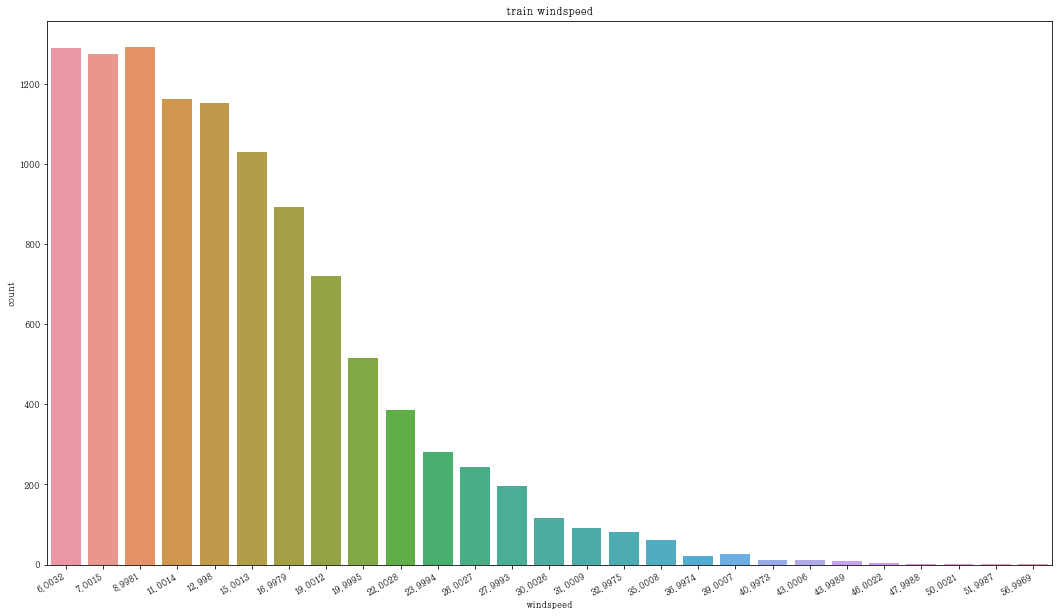

In [24]:
#0값을 조정
train2 = predict_ws(train)
fig, ax1 = plt.subplots()
fig.set_size_inches(18,10)
plt.sca(ax1)
plt.xticks(rotation =30, ha= 'right')
ax1.set(ylabel = 'Count',title = 'train windspeed')
sns.countplot(data = train2, x= 'windspeed',ax = ax1)

In [40]:
#풍속값 0 -> 예측값 처리 후
train2.windspeed.describe()

count    10886.000000
mean        14.026692
std          7.040906
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

# Feature Selection
- 신호와 잡음을 구분한다.
- 피처가 많다고 무조건 좋은 성능을 내지 않는다. (과적합 위험)
- 피처를 하나씩 추가하고 변경해 나가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [26]:
#연속형 feature = ['temp', 'humidity', ' windspeed', ' atemp'] 수치가 정도를 나타냄
#범주형 featrue = ['season', 'holiday', 'workingday',..] 등 수치가 정도를 나타내는게 아닐때
#범주형은 type을 category로 변경한다.
categorical_feature_names= ['season', 'holiday','workingday','weather','dayofweek','month','year','hour']
for val in categorical_feature_names:
    train2[val] = train2[val].astype('category')
    test[val] = test[val].astype('category')


In [27]:
feature_name = ['season', 'weather', 'temp', 'atemp', 'humidity','windspeed','year','hour','dayofweek','holiday','workingday']

In [28]:
x_train = train2[feature_name]
x_train.tail()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
10881,4,2,16.40,20.455,87,7.0015,2012,12,0,0,1
10882,4,2,17.22,21.210,88,8.9981,2012,15,0,0,1
10883,4,1,15.58,19.695,94,8.9981,2012,8,1,0,1
10884,4,1,13.94,16.665,49,12.9980,2012,22,1,0,1
10885,4,1,12.30,15.910,61,6.0032,2012,0,2,0,1


In [29]:
x_test = test[feature_name]
x_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [30]:
label_name = 'count'
y_train = train2[label_name]
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score

- RMSLE :과대 평가된 항목보다는 과소평가 된 항목에 페널티를 준다.



In [31]:
from sklearn.metrics import make_scorer

def rmsle(predicted_val, actual_val):
    #배열 형태로 바꿔준다.
    predicted_val = np.array(predicted_val)
    actual_val = np.array(actual_val)
    
    #예측값과 실제 값에 1을 더하고 로그 씌움
    log_p = np.log(predicted_val+1)
    log_a = np.log(actual_val+1)
    
    #예측값과 실제값을 빼주고 제곱을 해준다.
    differ = np.square(log_p - log_a)
    
    #평균을 낸다.
    m_differ = differ.mean()
    
    #다시 루트를 씌움
    score = np.sqrt(m_differ)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer


make_scorer(rmsle)

# 검증 
- Cross Validation 교차검증 : 일반화 성능을 측정하기 위해 데이터를 여러번 반복해서 나누고 여러 모델을 학습한다.
-> KFold 교차검증

In [32]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#nsplits = 몇개로 나눌 것인지(부분집합)
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

## RandomForest

In [33]:
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []
model = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state = 0)
%time score = cross_val_score(model, x_train, y_train, cv = k_fold, scoring = rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 17.5 s
Score= 0.33127


## Train

In [34]:
#학습시킴 ( 피처와 레이블을 넣어줌)
model.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
#예측
predictions = model.predict(x_test)
print(predictions.shape)
predictions

(6493,)


array([ 12.43,   5.14,   4.27, ..., 104.17, 101.46,  46.92])

[Text(0.5, 1.0, 'test')]

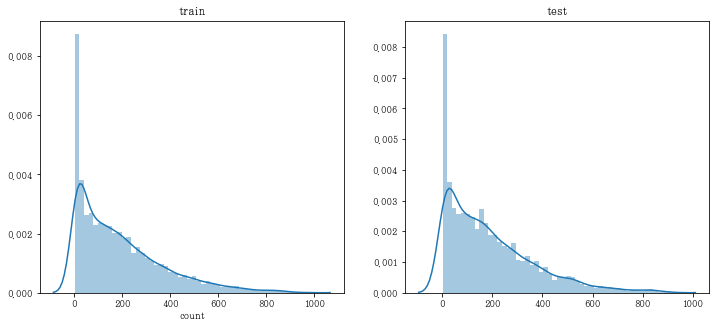

In [36]:
#예측한 데이터 시각화
fig,(ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax =ax1, bins = 50)
ax1.set(title = 'train')
sns.distplot(predictions, ax = ax2, bins = 50)
ax2.set(title = 'test')

# Submit

In [37]:
sub = pd.read_csv('Desktop/데이터분석/Bike/sampleSubmission.csv')
sub['count'] = predictions
sub.head()

,datetime,count
0,2011-01-20 00:00:00,12.43
1,2011-01-20 01:00:00,5.14
2,2011-01-20 02:00:00,4.27
3,2011-01-20 03:00:00,3.40
4,2011-01-20 04:00:00,3.14


In [38]:
#sub.to_csv('Desktop/데이터분석/Bike/Score_{0:.5f}_submission.csv'.format(score),index = False)

In [39]:
#상위 몇퍼?
(447/3251)*100

13.749615502922177